# Проект по увеличению покупательской активности

Импорт библиотек.

In [1]:
!pip install shap -q
!pip install scikit-learn==1.1.3 -q
!pip install phik -q

import pandas as pd
import numpy as np 

from phik.report import plot_correlation_matrix

from phik import phik_matrix
import shap

import seaborn as sns
import matplotlib.pyplot as plt 



# загружаем классы для работы с пайплайнами
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# импортируем для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# импортируем метрики для оценки качества модели
from sklearn.metrics import roc_auc_score 

import warnings
warnings.filterwarnings("ignore")

In [2]:
def column(data): #функция для изменений в названиях столбцов
    data.columns = data.columns.str.lower() #делает все буквы строчными
    data.columns = data.columns.str.replace(' ', '_') #пробелы заменяет на нижнее подчеркивание
    
    return data

Изучим предоставленные данные.


Таблица `market_file` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности: «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Таблица `market_money` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка.
- `Выручка` — сумма выручки за период.

Таблица `market_time` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

Таблица `money` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

## Загрузка данных

In [3]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [4]:
column(market_file).head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
column(market_money).head(10)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [6]:
column(market_time).head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
column(money).head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Вывод:
загрузили данные, изменили названия столбцов

## Предобработка данных

Посмотрим на общую информацию для каждого датафрейма

In [8]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [9]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [10]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [11]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Типы данных во всех датафреймах корректные, пропущенных значений нет. 

Теперь проверим данные на дубликаты.

In [12]:
market_file.duplicated().value_counts()

False    1300
dtype: int64

In [13]:
market_money.duplicated().value_counts()

False    3900
dtype: int64

In [14]:
market_time.duplicated().value_counts()

False    2600
dtype: int64

In [15]:
money.duplicated().value_counts()

False    1300
dtype: int64

Явных дубликатов нет.

### Вывод:
Все столбцы имеют корректный тип данных, пропущенных значений нет, явных дубликатов нет.


## Исследовательский анализ данных

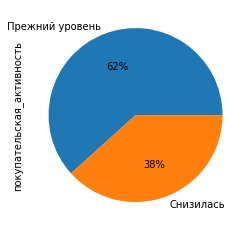

In [16]:
market_file['покупательская_активность'].value_counts().plot(kind='pie', autopct='%1.0f%%');

У 38% пользователей снизилась покупательская активность.

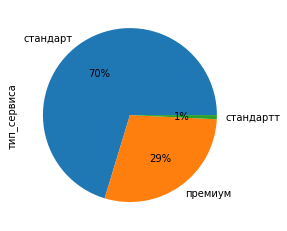

In [17]:
market_file['тип_сервиса'].value_counts().plot(kind='pie', autopct='%1.0f%%');

Уберем опечатку в категориальном значении.

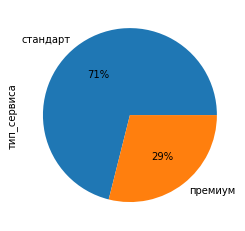

In [18]:
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'
market_file['тип_сервиса'].value_counts().plot(kind='pie', autopct='%1.0f%%');

У 71% пользователей тип сервиса 'стандарт', 29% имеют тип 'премиум'.

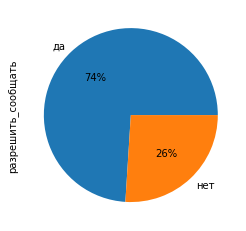

In [19]:
market_file['разрешить_сообщать'].value_counts().plot(kind='pie', autopct='%1.0f%%');

Три четверти покупателей не против рассылки.

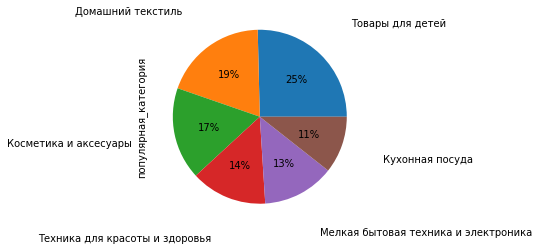

In [20]:
market_file['популярная_категория'].value_counts().plot(kind='pie', autopct='%1.0f%%', labeldistance=1.5);

Четверть покупателей совершает больше всего покупок в категории "товары для детей". Кухонная посуда является наименее популярной категорией.

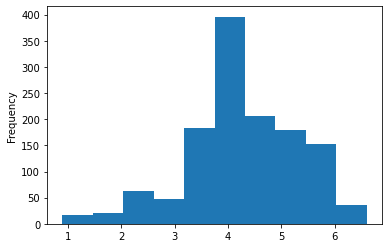

In [21]:
market_file['маркет_актив_6_мес'].plot(kind='hist', bins=10);

В большинстве случаев на покупателя приходится в среднем за пол года от 3 до 6 маркетинговых коммуникаций. 

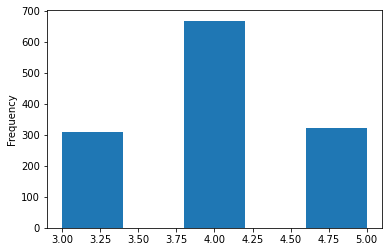

In [22]:
market_file['маркет_актив_тек_мес'].plot(kind='hist', bins=5);

3-5 маркетинговых коммуникаций было в этом месяце было у каждого клиента.

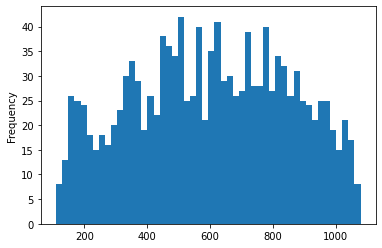

In [23]:
market_file['длительность'].plot(kind='hist', bins=50);

В датасете представленны как давно зарегестрированные пользователи, так и новые. На графике много пиков, скорее всего в это время проходила маркетинговая компания и количество новых зарегестрированных пользователей росло.

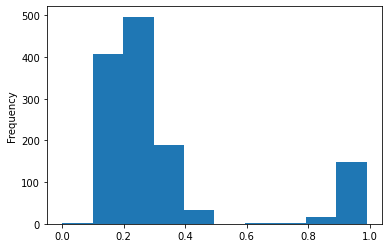

In [24]:
market_file['акционные_покупки'].plot(kind='hist', bins=10);

Есть 2 категории покупателей: те, кто покупает исключительно акционные товары и те у кого их доля составляет меньше 30% от общего числа покупок. Второй категории покупателей значительно больше.

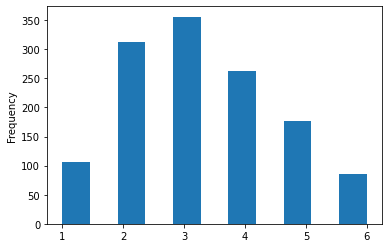

In [25]:
market_file['средний_просмотр_категорий_за_визит'].plot(kind='hist', bins=11);

Есть как покупатели, интересующиеся товарами только в одной категории, так и просматривающими все. Большинство пользователей просматривает от 2 до 4 категорий товаров.

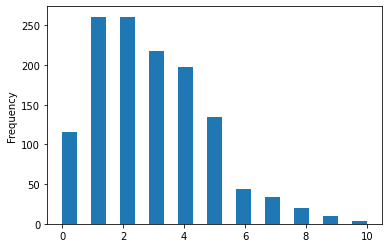

In [26]:
market_file['неоплаченные_продукты_штук_квартал'].plot(kind='hist', bins=21);

Подавляющее большинство пользователей имеет неоплаченные товары в корзине, в основном от 1 до 5 штук, есть так же те, у кого неоплаченных товаров в корзине нет.

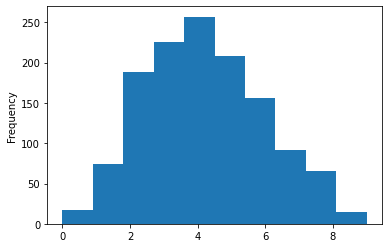

In [27]:
market_file['ошибка_сервиса'].plot(kind='hist',  bins=10);

Почти все пользователи хоть раз сталкивались с проблемами на сайте, большинство пользователей столкнулись с 2-6 сбоями в работе сервиса.

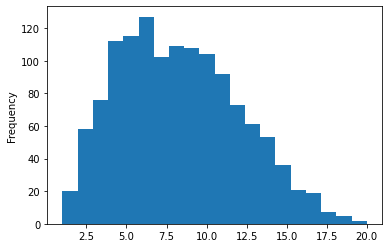

In [28]:
market_file['страниц_за_визит'].plot(kind='hist',  bins=20);

В среднем покупатели посещают от 3 до 12 страниц на сайте.

In [29]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


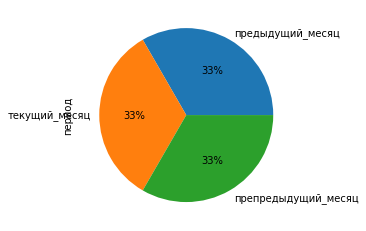

In [30]:
market_money['период'].value_counts().plot(kind='pie', autopct='%1.0f%%');

Данные разделены симметрично. Проверим не опечатка ли "препердыдущий"

In [31]:
market_money[['id', 'выручка']].duplicated().value_counts()



False    3893
True        7
dtype: int64

Совпало всего 7 значений, значит здесь представленны данные за три месяца.

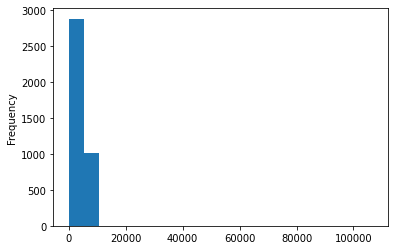

In [32]:
market_money['выручка'].plot(kind='hist', bins=20);

Выглядит максимально странно, возможно есть пару очень больших значений.

In [33]:
market_money['выручка'].sort_values()

0            0.0
2            0.0
34           0.0
35           0.0
28           0.0
          ...   
2388      7547.8
1481      7557.0
262       7605.3
435       7799.4
98      106862.2
Name: выручка, Length: 3900, dtype: float64

Есть одно значение больше ста тысяч.

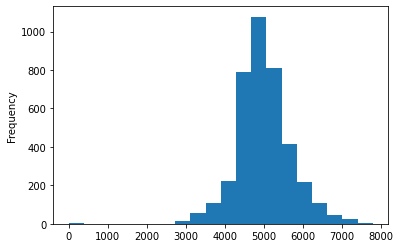

In [34]:
market_money['выручка'].drop(98).plot(kind='hist', bins=20);

В осоновном выручка с одного клиента составляет 4-6 тысяч. Аномльно большое значение заменим медианным

In [35]:
market_money['выручка'][98] = market_money['выручка'].median()
market_money['выручка'][98]

4957.5

In [36]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


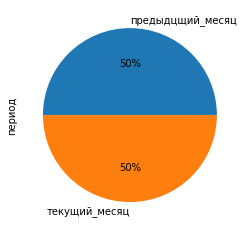

In [37]:
market_time['период'].value_counts().plot(kind='pie', autopct='%1.0f%%');

Исправим опечатку в значении.

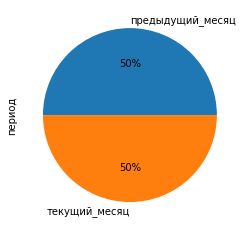

In [38]:
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
market_time['период'].value_counts().plot(kind='pie', autopct='%1.0f%%');

Распределенно поровну как и должно быть.

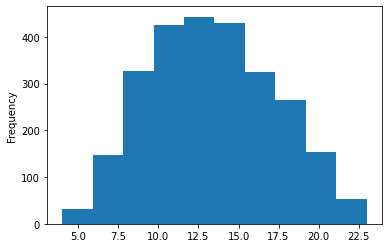

In [39]:
market_time['минут'].plot(kind='hist', bins=10);

Большинство пользователей проводят на сайте от 8 до 19 минут.

In [40]:
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


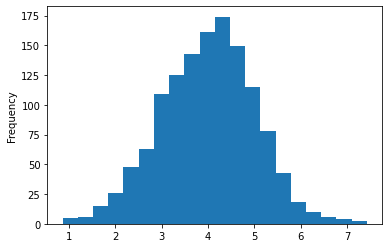

In [41]:
money['прибыль'].plot(kind='hist', bins=20);

Большинство значений прибыли расположенно от 3 до 5.5

### Вывод:
1. У 61.7% пользователей сохраниалсь прежняя покупательская ативность.
2. Преобладают пользователи со стандартным уровнем 71%.
3. 74% разрешила присылать покупателю дополнительные предложения о товаре.
4. Категории по популярности расположились в следующем виде:
    - Товары для детей - 25%.
    - Домашний текстиль - 19%.
    - Косметика и аксесуары - 17%.
    - Техника для красоты и здоровья - 14%
    - Мелкая бытовая техника и электроника - 13%
    - Кухонная посуда - 11% 
5. В большинстве случаев на покупателя приходится в среднем за пол года от 3 до 6 маркетинговых коммуникаций.
6. 3-5 маркетинговых коммуникаций было в этом месяце было у каждого клиента.
7. В датасете представленны как давно зарегестрированные пользователи, так и новые.
8. Есть 2 категории покупателей: те, кто покупает исключительно акционные товары и те у кого их доля составляет меньше 30% от общего числа покупок. Второй категории покупателей значительно больше.
9. Есть как покупатели, интересующиеся товарами только в одной категории, так и просматривающими все. Большинство пользователей просматривает от 2 до 4 категорий товаров.
10. Подавляющее большинство пользователей имеет неоплаченные товары в корзине, в основном от 1 до 5 штук, есть так же те, у кого неоплаченных товаров в корзине нет.
11. Почти все пользователи хоть раз сталкивались с проблемами на сайте, большинство пользователей столкнулись с 2-6 сбоями в работе сервиса.
12. В среднем покупатели посещают от 3 до 12 страниц на сайте.
13. В дф market_money в значении выручки было найдено аномально большое значение, его заменили медианным.
14. Была исправлена опечатка в названии периода 'предыдцщий_месяц'
15. Количество проведенного времени на сайте распределенно нормально, большинство значений лежит в пределах от 8 до 19 минут.
16. Значение прибыли тоже распределенно нормально.

## Объединение таблиц

In [42]:
df_full = market_file.copy(deep=True)

In [43]:
market_pred_pred_period = (
    market_money[market_money['период'] == 'препредыдущий_месяц'] #отбиреам в дф строки со значения периода 
    .rename(columns={'выручка':'препредыдущий_период_выручка'}) #переименовываем значения прибыли
    [['id', 'препредыдущий_период_выручка']] #в дф идет значение выручки за определенный период и id
)

In [44]:
market_pred_period = (
    market_money[market_money['период'] == 'предыдущий_месяц']
    .rename(columns={'выручка':'предыдущий_период_выручка'})
    [['id', 'предыдущий_период_выручка']]
)

In [45]:
market_period = (
    market_money[market_money['период'] == 'текущий_месяц']
    .rename(columns={'выручка':'текущий_период_выручка'})
    [['id', 'текущий_период_выручка']]
)

In [46]:
df_full = df_full.merge(market_period, on='id', how='inner') #объединяем ранее полученные дф
df_full = df_full.merge(market_pred_period, on='id', how='inner')
df_full = df_full.merge(market_pred_pred_period, on='id', how='inner')

In [47]:
market_time_pred_period = (
    market_time[market_time['период'] == 'предыдущий_месяц']
    .rename(columns={'минут':'пердыдущий_месяц_время'})
    [['id', 'пердыдущий_месяц_время']]
)

In [48]:
market_time_period = (
    market_time[market_time['период'] == 'текущий_месяц']
    .rename(columns={'минут':'текущий_месяц_время'})
    [['id', 'текущий_месяц_время']]
)

In [49]:
df_full = df_full.merge(market_time_pred_period, on='id', how='inner')
df_full = df_full.merge(market_time_period, on='id', how='inner')

In [50]:
df_full.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_период_выручка,предыдущий_период_выручка,препредыдущий_период_выручка,пердыдущий_месяц_время,текущий_месяц_время
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,3293.1,0.0,0.0,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,8,11


In [51]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [52]:
df_full = df_full.loc[((df_full['текущий_период_выручка'] !=0) &
            (df_full['предыдущий_период_выручка'] !=0) &
            (df_full['препредыдущий_период_выручка'] !=0))]

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

### Вывод:
Объединили три датафрейма в один и отобрали и отобрали пользователей, которые совершили хотя бы одну покупку за предоставленный период.

##  Корреляционный анализ

Проведем кореляционнцый анализ 

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'текущий_период_выручка', 'предыдущий_период_выручка', 'препредыдущий_период_выручка', 'пердыдущий_месяц_время', 'текущий_месяц_время']


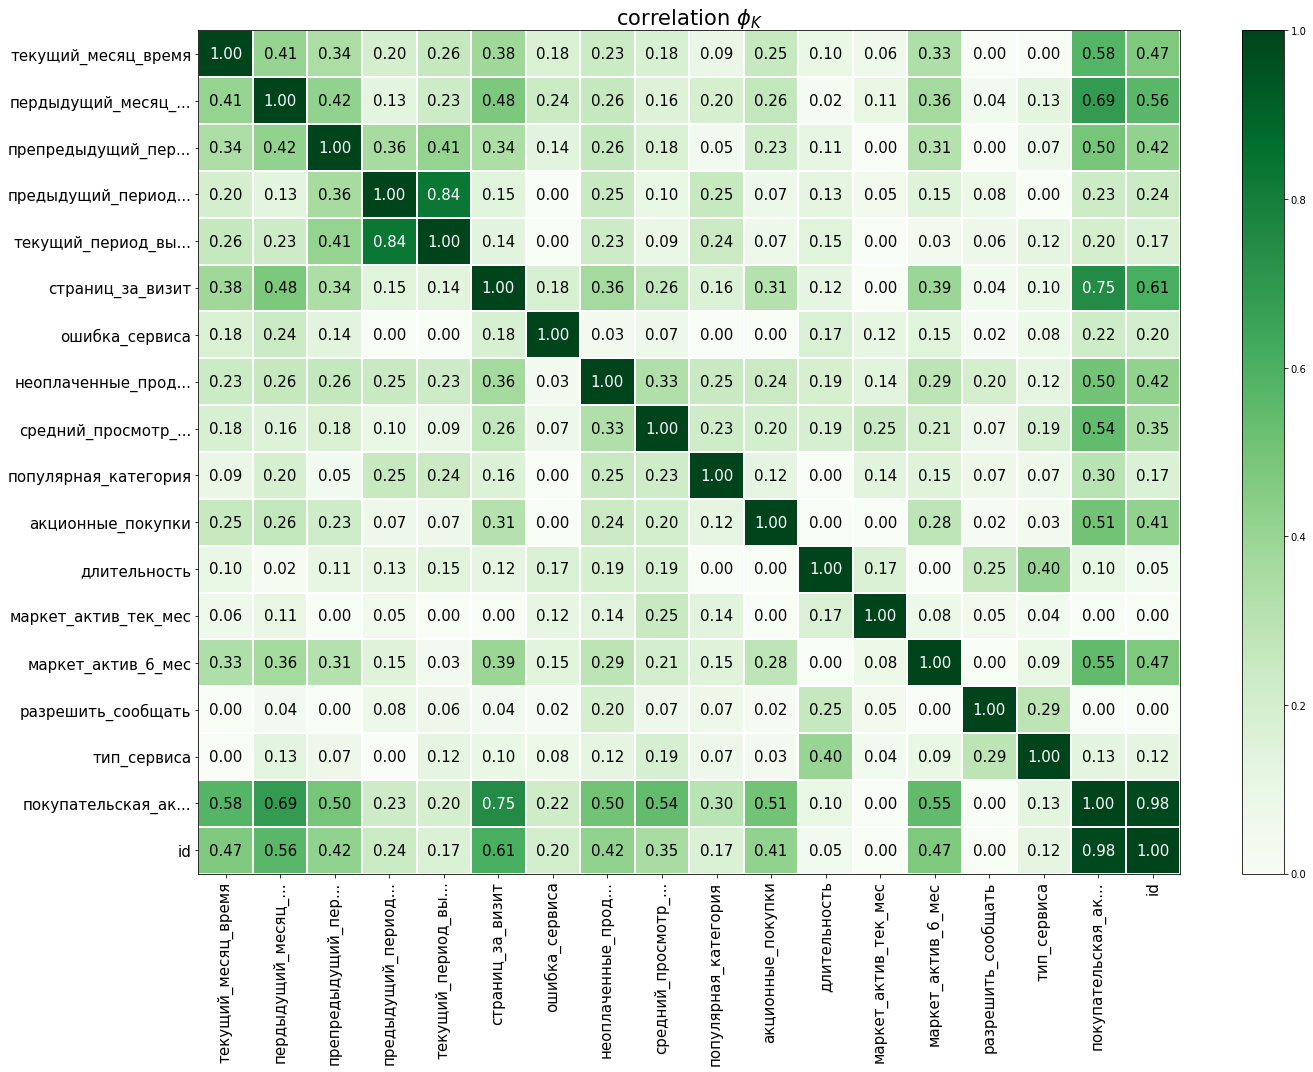

In [53]:
phik_overview = phik_matrix(df_full)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Мультиколлинеарность присутствуем между двумя признаками id и покупательская_активность. При обучении модели не будем включать в данные значения id, а из самой таблицы удалаять не будем.

## Использование пайплайнов

Закодируем целевой признак. Знчение 1 - покупательская активность снизилась, 0 - покупательская активность на прежнем уровне.

In [54]:
df_full.loc[df_full['покупательская_активность'] == 'Прежний уровень', 'покупательская_активность'] = 0
df_full.loc[df_full['покупательская_активность'] == 'Снизилась', 'покупательская_активность'] = 1
df_full['покупательская_активность'] = df_full['покупательская_активность'].astype('int')
df_full['покупательская_активность'].value_counts()

0    802
1    495
Name: покупательская_активность, dtype: int64

Теперь определим лучшую модель.

In [55]:
X = df_full.drop(columns=['покупательская_активность', 'id'], axis=1)
y = df_full['покупательская_активность']
df_full = df_full.reset_index(drop=True)
RANDOM_STATE = 777
TEST_SIZE = 0.25
 
# разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
 
# создаём списки с названиями признаков
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал','ошибка_сервиса',
               'страниц_за_визит', 'препредыдущий_период_выручка', 'предыдущий_период_выручка', 
               'текущий_период_выручка', 'текущий_месяц_время', 'пердыдущий_месяц_время']
 
# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
    
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)


# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
 
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
 
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'model__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
 
    {
        'models': [SVC(kernel='rbf', probability=True)],
        'models__degree': range(2, 10),
        'models__C': range(1, 10),
        'models__gamma': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

#data_preprocessor.fit(X_train)
#X_preprocessed = data_preprocessor.transform(X_test)



randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
 
randomized_search.fit(X_train, y_train)
 

 
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['маркет_актив

In [56]:
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.8856925052158563


### Вывод:
Лучшей оказалась модель опорных веторов с параметрами: C=5, degree=6, gamma=3, probability=True и скалером - StandardScaler
Метрику качества используем ROC-AUC, потому что у нас есть дисбаланс классов 62% у класса 0 и 38% у класса 1, а так же эта метрика не зависит от порога класификации.


## Анализ важности признаков

С помощью метода  SHAP посмотрим как отдельный признак помог присвоить модели итоговое значение целевого.

Using 972 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/325 [00:00<?, ?it/s]

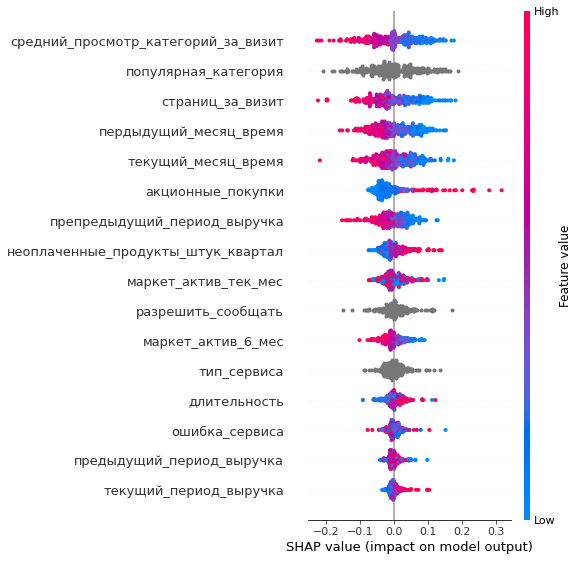

In [57]:
explainer = shap.KernelExplainer(randomized_search.predict_proba, X_train, keep_index=True)
shap_values = explainer(X_test)[:, :, 1]
shap.summary_plot(shap_values, X_test)

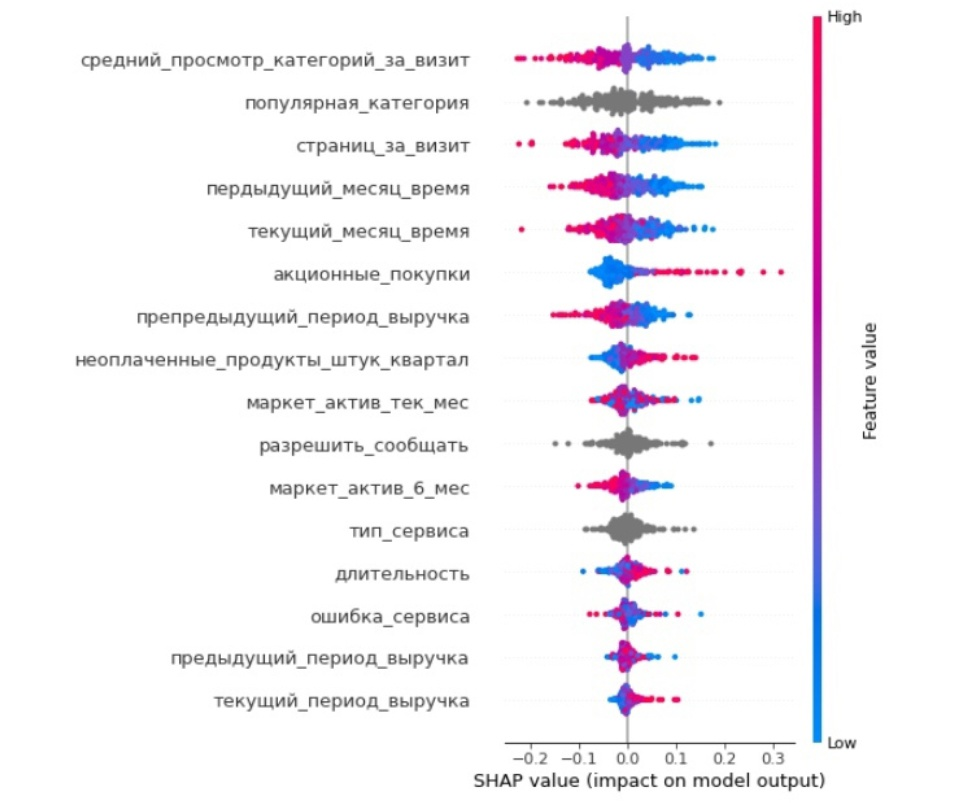

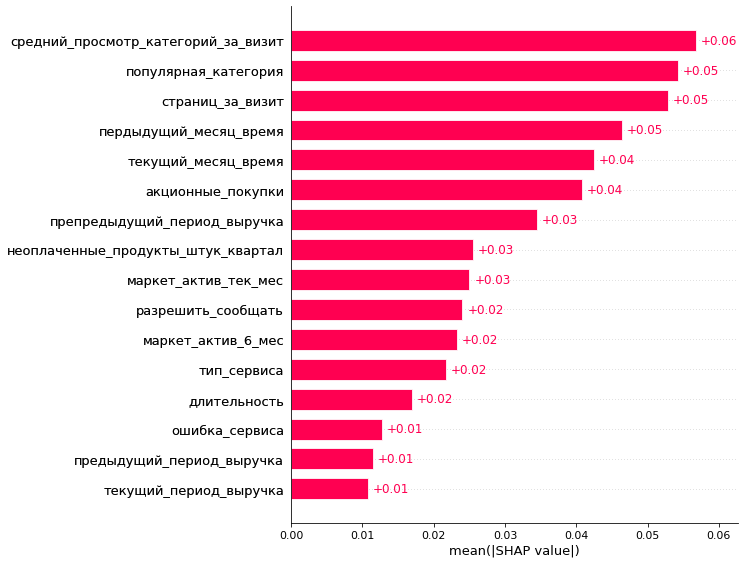

In [58]:
shap.plots.bar(shap_values, max_display=16)

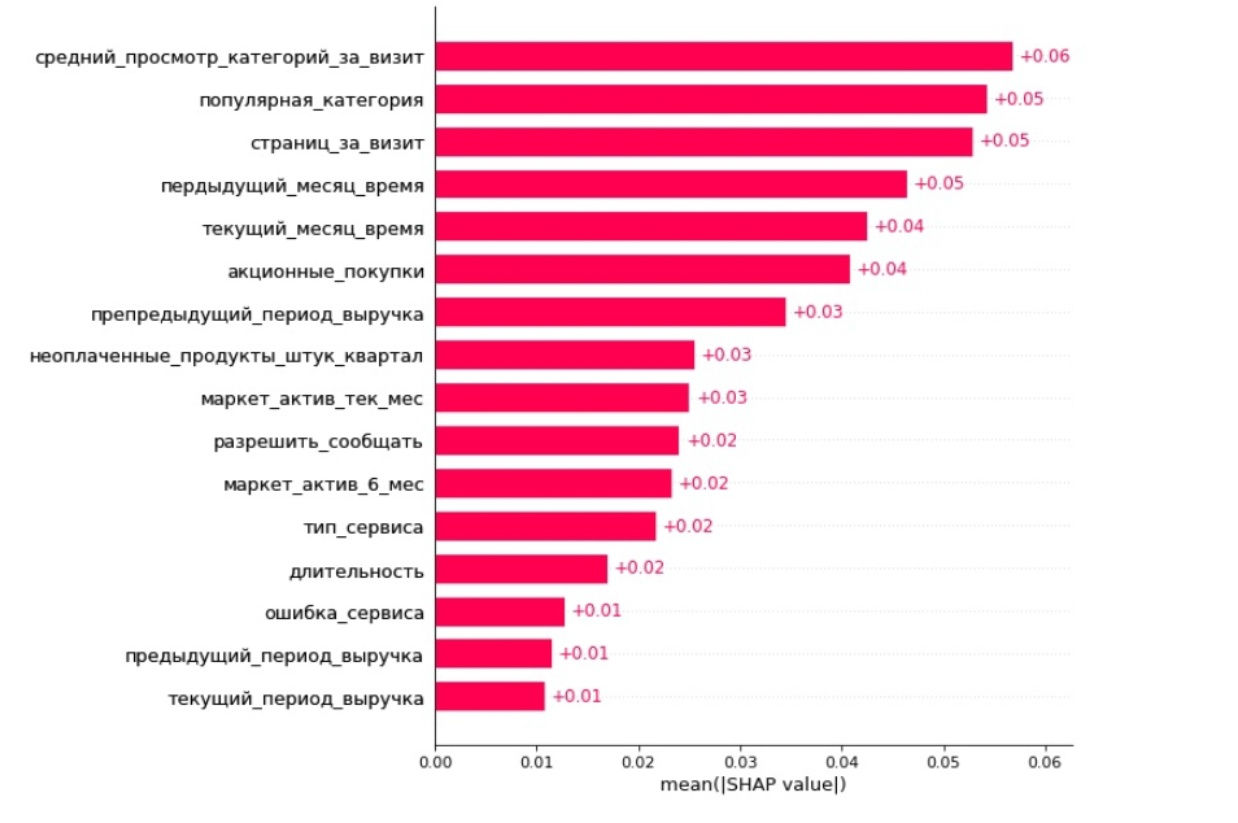

### Вывод
Наиболее важными оказались признаки показывающие средний просмотр категорий за визит, популярную категорию, колличество посещенных страниц за визит, время на сайте и акционные покупки. 

Покупатели с большой долей акционных товоров показывают снижение покупательской активности.

## Сегментация покупателей

Определим группу покупателей с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Выбрал эту группу, т.к. с уходом пусть и небольшого количества пользователей из этой группы может заметно упасть прибыль компании. 

In [58]:
best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X)[:, 1] #записываем значения вероятности снижения покупательской способностии

Посмотрим на распределение значений прибыли

In [59]:
money.прибыль.describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

За высокую прибыль примем значения 75 процентиля

In [60]:
df_segment = df_full.merge(money, on='id') #создаем новую таблицу и добовлаем туда данные о прибили
df_segment['вероятность_снижения'] = predictions #создаем столбец показывающий вероятность снижения покупательской способности

#оставляем только пользователей с показателем прибыли больше чем у 3/4 покупателей
df_segment = df_segment[df_segment['прибыль'] > 4.67]
df_segment.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,текущий_период_выручка,предыдущий_период_выручка,препредыдущий_период_выручка,пердыдущий_месяц_время,текущий_месяц_время,прибыль,вероятность_снижения
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,11,13,4.87,0.985496
6,215355,1,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3772.6,3263.0,4749.0,12,10,5.26,0.985490
7,215356,1,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4566.4,4146.5,4433.0,6,7,4.93,0.816738
17,215368,1,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,2,6,1,5591.6,5823.0,4536.0,11,9,6.27,0.536607
33,215384,1,стандарт,да,4.0,4,1020,0.34,Косметика и аксесуары,2,3,8,3,4010.4,3584.0,4226.0,11,12,4.78,0.985497


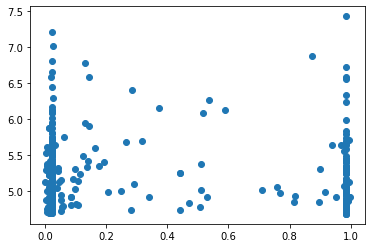

In [61]:
plt.scatter(df_segment.вероятность_снижения, df_segment.прибыль,)

На графике видно 3 кластера которые показывают разную вероятность снижения покупательской способности. Нас интересует в данном случае правый кластер - высокая степень снижения покупательской кативности. Степень порога поределим как 0.7 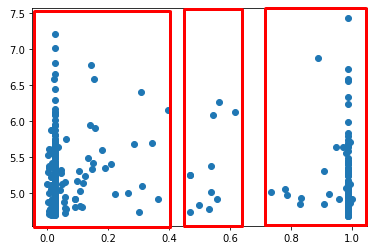

In [62]:
threshold = 0.7  #отбираем клиентов с вероятностью снижения активности свыше 0.7
df_segment = df_segment[df_segment['вероятность_снижения'] > threshold]

In [63]:
df_segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 2 to 1256
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   102 non-null    int64  
 1   покупательская_активность            102 non-null    int64  
 2   тип_сервиса                          102 non-null    object 
 3   разрешить_сообщать                   102 non-null    object 
 4   маркет_актив_6_мес                   102 non-null    float64
 5   маркет_актив_тек_мес                 102 non-null    int64  
 6   длительность                         102 non-null    int64  
 7   акционные_покупки                    102 non-null    float64
 8   популярная_категория                 102 non-null    object 
 9   средний_просмотр_категорий_за_визит  102 non-null    int64  
 10  неоплаченные_продукты_штук_квартал   102 non-null    int64  
 11  ошибка_сервиса                 

Получился датафрейм с клиентами, приносящими максимальную прибыли и которые с высокой вероятностью снизят покупательскую активность. 

Сравним графики с нашей группой и всеми клиентами

In [68]:
df_full_s = df_full.loc[df_full['покупательская_активность'] == 1] #датафрейм со сниженной покупательской активностью
df_full_p = df_full.loc[df_full['покупательская_активность'] == 0] #датафрейм с прежним уронем покупательской активности

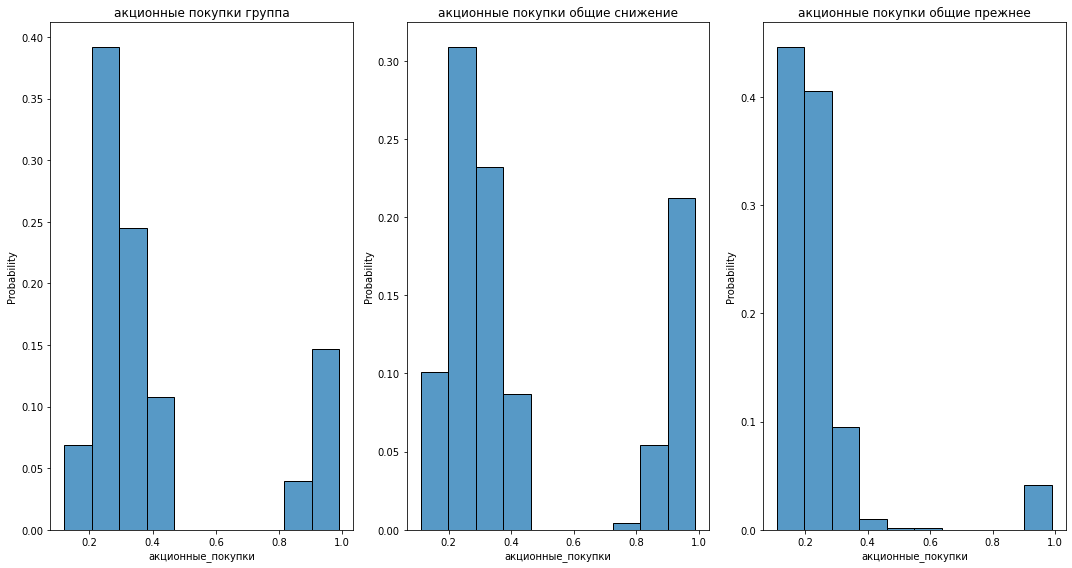

In [85]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.histplot(df_segment['акционные_покупки'], stat='probability', bins=10)
plt.title('акционные покупки группа')

plt.subplot(1, 3, 2)
sns.histplot(df_full_s['акционные_покупки'], stat='probability', bins=10)
plt.title('акционные покупки общие снижение')

plt.subplot(1, 3, 3)
sns.histplot(df_full_p['акционные_покупки'], stat='probability', bins=10)
plt.title('акционные покупки общие прежнее')

plt.tight_layout()
plt.show()

Большая доля приобретенных акционных товаров выступает индикатором снижения покукпательской активности. Это может быть связанно  с тем, что люди просто дожидаются акций на нужные им товары и без них не покупают ничего. 

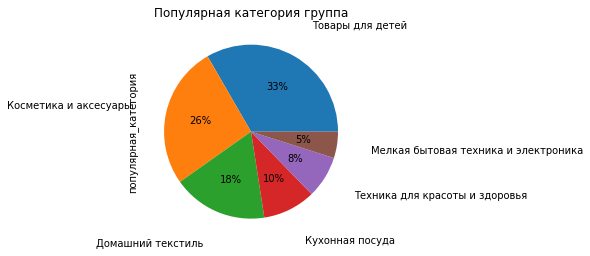

In [98]:
df_segment['популярная_категория'].value_counts().plot(kind='pie', autopct='%1.0f%%',
                                                       labeldistance=1.4, title='Популярная категория группа');

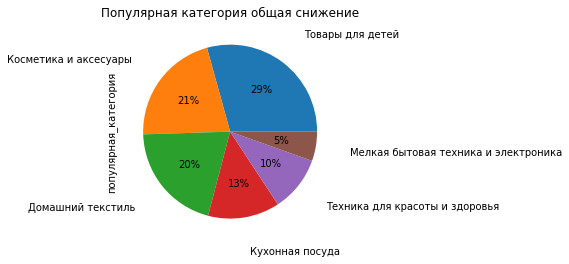

In [74]:
df_full_s['популярная_категория'].value_counts().plot(kind='pie', autopct='%1.0f%%',
                                                       labeldistance=1.4, title='Популярная категория общая снижение');

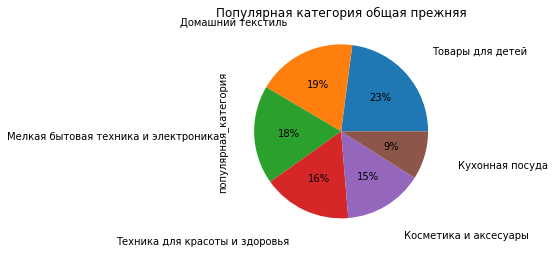

In [75]:
df_full_p['популярная_категория'].value_counts().plot(kind='pie', autopct='%1.0f%%',
                                                       labeldistance=1.4, title='Популярная категория общая прежняя');

Покупатели из выделенного нами сегмента значительно чаще приобретаеют товары для детей, косметику и аксессуары, значительно меньше приобретают из категорий мелкой бытовой техники и техники для красоты и здоровья. Показатели схожи со всеми покупателями, у которых снизилась активность. У нашей группы значительно проседает интерес в категориях мелкой бытовой техники и электроники, и техники для красоты и здоровья.

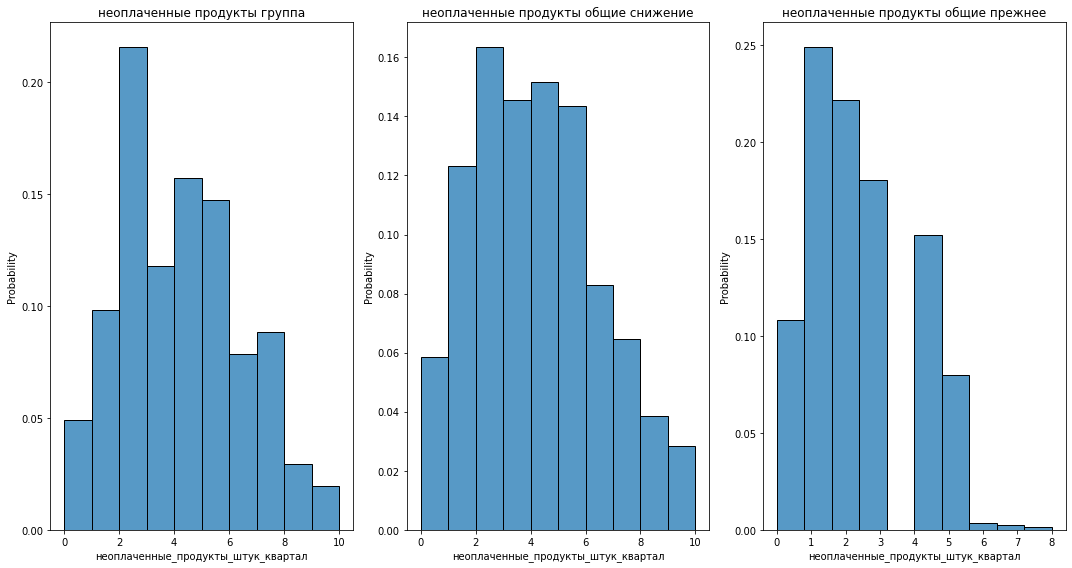

In [86]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.histplot(df_segment['неоплаченные_продукты_штук_квартал'], stat='probability', bins=10)
plt.title('неоплаченные продукты группа')

plt.subplot(1, 3, 2)
sns.histplot(df_full_s['неоплаченные_продукты_штук_квартал'], stat='probability', bins=10)
plt.title('неоплаченные продукты общие снижение')

plt.subplot(1, 3, 3)
sns.histplot(df_full_p['неоплаченные_продукты_штук_квартал'], stat='probability', bins=10)
plt.title('неоплаченные продукты общие прежнее')

plt.tight_layout()
plt.show()

Большое количество неоплаченных товаров в корзине также сведетельствует о снижении покупательской активности. Можно посмотреть на количество сбоев, возможно это препятствовало покупке и дальнйшем оставлении вещей в корзине.

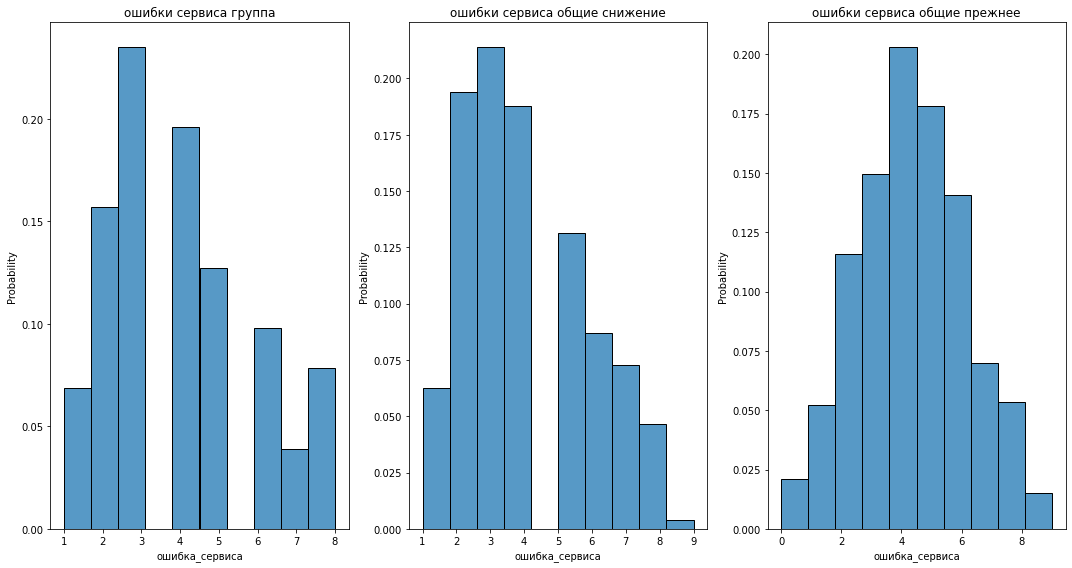

In [99]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.histplot(df_segment['ошибка_сервиса'], stat='probability', bins=10)
plt.title('ошибки сервиса группа')

plt.subplot(1, 3, 2)
sns.histplot(df_full_s['ошибка_сервиса'], stat='probability', bins=10)
plt.title('ошибки сервиса общие снижение')

plt.subplot(1, 3, 3)
sns.histplot(df_full_p['ошибка_сервиса'], stat='probability', bins=10)
plt.title('ошибки сервиса общие прежнее')

plt.tight_layout()
plt.show()


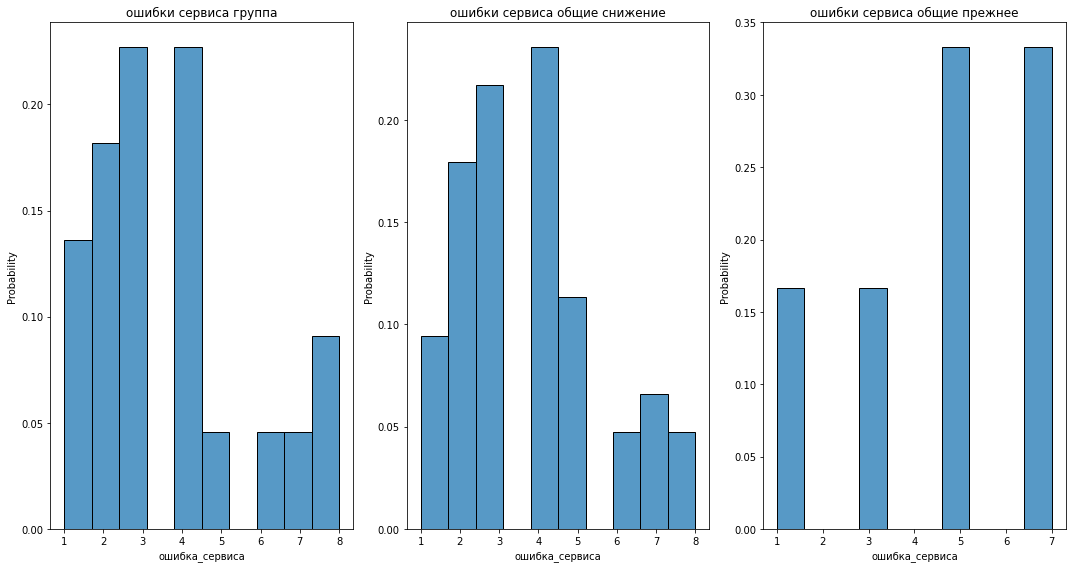

In [101]:
#тот же самый график, но только с информациях о сбоях у тех, у кого больше 5 неоплаченных товаров
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.histplot(df_segment[df_segment['неоплаченные_продукты_штук_квартал'] > 5]['ошибка_сервиса'], stat='probability', bins=10)
plt.title('ошибки сервиса группа')

plt.subplot(1, 3, 2)
sns.histplot(df_full_s[df_full_s['неоплаченные_продукты_штук_квартал'] > 5]['ошибка_сервиса'], stat='probability', bins=10)
plt.title('ошибки сервиса общие снижение')

plt.subplot(1, 3, 3)
sns.histplot(df_full_p[df_full_p['неоплаченные_продукты_штук_квартал'] > 5]['ошибка_сервиса'], stat='probability', bins=10)
plt.title('ошибки сервиса общие прежнее')

plt.tight_layout()
plt.show()

Сбои не влияют на неоплаченные товары в корзине и соответсвтенно, на снижение покупательской активности.

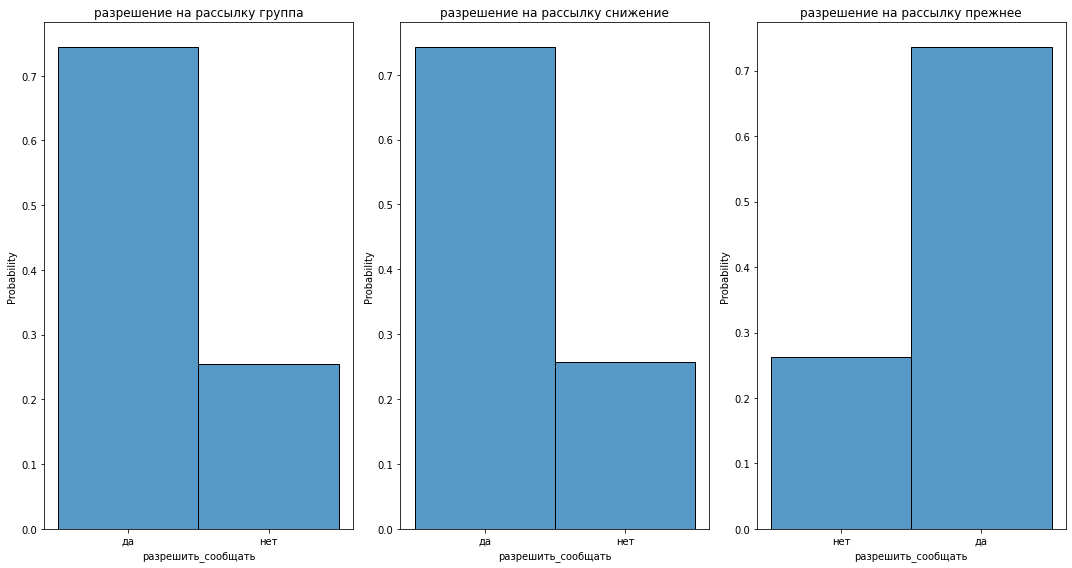

In [103]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
sns.histplot(df_segment['разрешить_сообщать'], stat='probability', bins=10)
plt.title('разрешение на рассылку группа')

plt.subplot(1, 3, 2)
sns.histplot(df_full_s['разрешить_сообщать'], stat='probability', bins=10)
plt.title('разрешение на рассылку снижение')

plt.subplot(1, 3, 3)
sns.histplot(df_full_p['разрешить_сообщать'], stat='probability', bins=10)
plt.title('разрешение на рассылку прежнее')

plt.tight_layout()
plt.show()


Разрешение пользователей на рассылку никак не влияет на покупательскую активность.

### Вывод: 
У сформированной группы большая доля акционных покупок, самые популярные категории: товары для детей, косметика и аксесуары, домашний текстиль. Меньше всего они заинтересованны в мелкой бытовой технике и электронике. В корзине у них сравнительно много неоплаченных товаров в карзине.

## Общий вывод:

1. Задача:  разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность
2. Данные описаны в самом начале проекта. 
    С данными провели следующую работу:
    - исправили ошибки в названиях категориальных значений
    - создали единый датафрейм со всеми значениями
3. Для поиска лучшей модели создали пайплайн, который перебрал множество моделей с разными гиперпараметрами.
4. Лучшей оказалась модель опорных веторов с параметрами: C=5, degree=6, gamma=3, probability=True и скалером - MinMaxScaler.
5. Для группы покупателей с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью:     
    Так как большая доля акционных товаров служит индикатором снижения покупательской активности, можно ввести бонусную систему, где за покупки товаров без акций будет начисляться кешбэк, который можно будет потратить на следующие покупки. Это в теории может быть стимулом для покупателей не дожидаться акций на товары, а покупать сразу все необходимое вне зависимости от наличия акций, а также возратиться вновь к нашему сервису. Если это сработает, то можно применить данный подход ко всем клиентам. Конкретно для выбранной группы можно таргетированно продвигать мелкую бытовую технику и электронику с посылом, что эти товары упростят бытовые дела  и у родителей будет больше времени, которое можно уделить для своих детей, т.к. по сравнению с общим набором клиентов, они на 10% чаще акценитруют внимание на товарах для детей.